In [1]:
# -----------------------------
# Step 1: Setup and Data Loading
# -----------------------------

import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import torchvision.models as models
import torch.nn as nn

In [39]:
# Load and clean the data
df = pd.read_pickle('combined_df.pkl')
df = df.dropna(subset=['image'])

In [3]:
df_old = pd.read_pickle('balanced_df_with_images.pkl')

In [4]:
df.columns, df_old.columns

(Index(['name', 'description', 'label', 'base_name', 'emotion_category',
        'image'],
       dtype='object'),
 Index(['base_name', 'emotion_category', 'image'], dtype='object'))

In [40]:
# -----------------------------
# Step 2: Apply engagement_type mapping
# -----------------------------

engagement_mapping = {
    "not engaged": [
        "isolation", "neglect", "pity", "sentimentality", "loneliness", "gloom", "alienation", "defeat", "anguish", "dejection",
        "hopelessness", "melancholy", "depression", "homesickness", "longing"
    ],
    "engaged-positive": [
        "lust", "desire", "infatuation", "passion", "attraction", "liking",
        "excitement", "hope", "optimism", "eagerness", "zeal", "arousal", "joy", "zest",
        "cheerfulness", "happiness", "elation", "rapture", "enjoyment", "gladness",
        "bliss", "gaiety", "jubilation", "delight", "euphoria", "jolliness", "joviality",
        "glee", "ecstasy", "caring", "love", "tenderness", "affection", "adoration",
        "fondness", "compassion", "sympathy", "pleasure", "pride", "satisfaction",
        "contentment", "relief", "triumph", "enthusiasm", "amusement", "surprise",
        "astonishment", "amazement", "shock", "thrill", "exhilaration", "enthrallment"
    ],
    "engaged-negative": [
        "irritation", "wrath", "annoyance", "rage", "aggravation", "anger", "resentment",
        "grumpiness", "frustration", "fury", "hostility", "exasperation", "outrage",
        "grouchiness", "spite", "unhappiness", "disappointment", "insult",
        "rejection", "agitation", "bitterness", "hate",
        "disgust", "dislike", "contempt", "scorn", "displeasure", "envy", "loathing",
        "jealousy", "revulsion", "nervousness", "alarm", "fear", "fright", "horror",
        "terror", "dread", "hysteria", "dismay", "apprehension", "worry", "panic",
        "tenseness", "uneasiness", "anxiety", "suffering", "hurt", "agony",
        "insecurity", "distress", "torment", "sadness", "grief", "glumness", "sorrow", "despair", "misery", "woe", "regret", "guilt", "shame", "embarrassment", "mortification",
        "remorse", "humiliation"
    ]
}

flat_mapping = {label: k for k, v in engagement_mapping.items() for label in v}
df['engagement_type'] = df['label'].map(flat_mapping)

In [41]:
# -----------------------------
# Step 3: Balance the dataset
# -----------------------------

min_class_size = df['engagement_type'].value_counts().min()
df_balanced = (
    df.groupby('engagement_type', group_keys=False)
      .apply(lambda x: x.sample(n=min_class_size, random_state=42))
      .reset_index(drop=True)
)


C:\Users\alina\AppData\Local\Temp\ipykernel_21764\3706752987.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min_class_size, random_state=42))


In [42]:
df_balanced.columns

Index(['name', 'description', 'label', 'base_name', 'emotion_category',
       'image', 'engagement_type'],
      dtype='object')

In [36]:
# -----------------------------
# Step 3: Balance the dataset
# -----------------------------

min_class_size = df['engagement_type'].value_counts().min()
df_balanced = (
    df.groupby('engagement_type', group_keys=False)
      .apply(lambda x: x.sample(n=min_class_size, random_state=42))
      .reset_index(drop=True)
)

# Encode labels
le = LabelEncoder()
df_balanced['label_encoded'] = le.fit_transform(df_balanced['engagement_type'])

# Add image IDs for merging
df_balanced['image_id'] = [hash(img.numpy().tobytes()) for img in df_balanced['image']]

C:\Users\alina\AppData\Local\Temp\ipykernel_21764\2837328847.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min_class_size, random_state=42))


In [37]:
df_balanced.to_pickle('df_balanced_new.pkl')

In [7]:
# -----------------------------
# Step 4: Prepare Dataset and DataLoader
# -----------------------------

class EngagementDataset(Dataset):
    def __init__(self, dataframe):
        self.images = dataframe['image'].tolist()
        self.labels = dataframe['label_encoded'].tolist()
        self.image_ids = dataframe['image_id'].tolist()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx], self.image_ids[idx]

# Split
temp_train, val_df = train_test_split(df_balanced, test_size=0.2, random_state=42)
val_dataset = EngagementDataset(val_df)
val_loader = DataLoader(val_dataset, batch_size=32)

In [8]:
# -----------------------------
# Step 5: Load Pretrained Model
# -----------------------------

model = torch.load("alexnet_full_model.pth", map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
model.eval()


C:\Users\alina\AppData\Local\Temp\ipykernel_21764\2640455512.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("alexnet_full_model.pth", map_location=to

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.6, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [9]:
# -----------------------------
# Step 6: Run Inference
# -----------------------------

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

predictions, true_labels, image_ids = [], [], []

with torch.no_grad():
    for images, labels, ids in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels)
        image_ids.extend(ids)

In [10]:
# -----------------------------
# Step 7: Assemble Result DataFrame
# -----------------------------

pred_df = pd.DataFrame({
    'image_id': image_ids,
    'predicted engagement type': le.inverse_transform(predictions),
    'engagement_type': le.inverse_transform(true_labels)
})

# Merge with original labels
label_lookup = df_balanced[['image_id', 'label', 'base_name']].drop_duplicates()

# 🔧 Ensure same type before merging
pred_df['image_id'] = pred_df['image_id'].astype(np.int64)
label_lookup['image_id'] = label_lookup['image_id'].astype(np.int64)

final_df = pred_df.merge(label_lookup, on='image_id', how='left')



In [11]:
final_df.head()

,image_id,predicted engagement type,engagement_type,label,base_name
0,-5050042526144181602,not engaged,engaged-positive,liking,shutterstock_liking_face_14_27
1,-8693516058325232591,engaged-negative,engaged-negative,anger,bigstockphoto_anger_portrait_1500_2
2,6867557541371928046,engaged-negative,engaged-negative,dislike,shutterstock_dislike_face_5_22
3,1655742408650393519,engaged-negative,engaged-negative,disgust,bigstockphoto_disgust_portrait_600_82
4,4829436139431931679,not engaged,not engaged,anguish,alamy_anguish_portrait_6_84


In [13]:
colored_df = df_old.merge(final_df, on = 'base_name', how = 'inner')

In [ ]:
df_old

In [16]:
final_df.shape, colored_df.shape

((2579, 5), (2235, 7))

In [18]:
colored_df.columns

Index(['base_name', 'emotion_category', 'image', 'image_id',
       'predicted engagement type', 'engagement_type', 'label'],
      dtype='object')

In [ ]:
colored_df.col

In [19]:
colored_df[(colored_df['engagement_type']=='engaged-negative') & (colored_df['predicted engagement type']=='engaged-positive')]['label'].value_counts()

label
agony             5
shame             5
disgust           4
unhappiness       4
fear              4
annoyance         4
rejection         3
distress          3
rage              2
hate              2
agitation         2
worry             2
anger             2
hurt              2
suffering         2
alarm             2
scorn             2
contempt          1
misery            1
sadness           1
compassion        1
lust              1
longing           1
guilt             1
dislike           1
embarrassment     1
regret            1
remorse           1
dismay            1
envy              1
bitterness        1
panic             1
fury              1
anxiety           1
fright            1
anguish           1
disappointment    1
hostility         1
resentment        1
humiliation       1
Name: count, dtype: int64

In [20]:
colored_df['label'].nunique()

130

In [21]:
colored_df[colored_df['label']=='shame'].shape

(27, 7)

In [22]:
colored_df['result'] = np.where(
    colored_df['predicted engagement type'] == colored_df['engagement_type'],
    'correct',
    'wrong'
)

In [23]:
colored_df[(colored_df['label']=='shame') & (colored_df['result']=='wrong')].sort_values(by='predicted engagement type')

,base_name,emotion_category,image,image_id,predicted engagement type,engagement_type,label,result
1905,bigstockphoto_shame_look_750_114,Shame / Guilt / Embarrassment,<PIL.Image.Image image mode=L size=48x48 at 0x...,6631560082453644523,engaged-negative,engaged-positive,shame,wrong
1906,bigstockphoto_shame_look_750_114,Shame / Guilt / Embarrassment,<PIL.Image.Image image mode=L size=48x48 at 0x...,6631560082453644523,engaged-negative,engaged-positive,shame,wrong
1910,shutterstock_shame_portrait_2_67,Shame / Guilt / Embarrassment,<PIL.Image.Image image mode=L size=48x48 at 0x...,3282459000362725902,engaged-positive,engaged-negative,shame,wrong
1961,bigstockphoto_shame_portrait_1650_57,Shame / Guilt / Embarrassment,<PIL.Image.Image image mode=L size=48x48 at 0x...,4895567337015993676,engaged-positive,engaged-negative,shame,wrong
1981,alamy_shame_portrait_9_57,Shame / Guilt / Embarrassment,<PIL.Image.Image image mode=L size=48x48 at 0x...,-8784577592051775998,engaged-positive,engaged-negative,shame,wrong
1999,alamy_shame_expression_5_18,Shame / Guilt / Embarrassment,<PIL.Image.Image image mode=L size=48x48 at 0x...,4686488242384452036,engaged-positive,engaged-negative,shame,wrong
2007,alamy_shame_face_6_22,Shame / Guilt / Embarrassment,<PIL.Image.Image image mode=L size=48x48 at 0x...,-776780472324648171,engaged-positive,engaged-negative,shame,wrong
1861,alamy_shame_face_9_64,Shame / Guilt / Embarrassment,<PIL.Image.Image image mode=L size=48x48 at 0x...,-2844178043037151128,not engaged,engaged-negative,shame,wrong
1889,alamy_shame_portrait_4_85,Shame / Guilt / Embarrassment,<PIL.Image.Image image mode=L size=48x48 at 0x...,-4818166699272270597,not engaged,engaged-negative,shame,wrong
1925,bigstockphoto_shame_portrait_750_86,Shame / Guilt / Embarrassment,<PIL.Image.Image image mode=L size=48x48 at 0x...,-3090499563865222803,not engaged,engaged-negative,shame,wrong


In [24]:
colored_df[(colored_df['label']=='shame') & (colored_df['result']=='correct')].sort_values(by='predicted engagement type')

,base_name,emotion_category,image,image_id,predicted engagement type,engagement_type,label,result
1862,alamy_shame_look_2_45,Shame / Guilt / Embarrassment,<PIL.Image.Image image mode=L size=48x48 at 0x...,-2769022101859889367,engaged-negative,engaged-negative,shame,correct
1865,alamy_shame_portrait_15_78,Shame / Guilt / Embarrassment,<PIL.Image.Image image mode=L size=48x48 at 0x...,1394431295151766502,engaged-negative,engaged-negative,shame,correct
1879,alamy_shame_emotion_6_30,Shame / Guilt / Embarrassment,<PIL.Image.Image image mode=L size=48x48 at 0x...,-2857641796388020947,engaged-negative,engaged-negative,shame,correct
1884,shutterstock_shame_expression_12_43,Shame / Guilt / Embarrassment,<PIL.Image.Image image mode=L size=48x48 at 0x...,-1322418482142219432,engaged-negative,engaged-negative,shame,correct
1891,alamy_shame_expression_2_77,Shame / Guilt / Embarrassment,<PIL.Image.Image image mode=L size=48x48 at 0x...,3297238609043598481,engaged-negative,engaged-negative,shame,correct
1904,shutterstock_shame_expression_13_17,Shame / Guilt / Embarrassment,<PIL.Image.Image image mode=L size=48x48 at 0x...,6025027089702919898,engaged-negative,engaged-negative,shame,correct
1912,alamy_shame_portrait_7_91,Shame / Guilt / Embarrassment,<PIL.Image.Image image mode=L size=48x48 at 0x...,2338861304350287648,engaged-negative,engaged-negative,shame,correct
1919,shutterstock_shame_portrait_9_89,Shame / Guilt / Embarrassment,<PIL.Image.Image image mode=L size=48x48 at 0x...,6350229175364412116,engaged-negative,engaged-negative,shame,correct
1921,shutterstock_shame_portrait_2_13,Shame / Guilt / Embarrassment,<PIL.Image.Image image mode=L size=48x48 at 0x...,8863993731099309623,engaged-negative,engaged-negative,shame,correct
1937,bigstockphoto_shame_face_1350_25,Shame / Guilt / Embarrassment,<PIL.Image.Image image mode=L size=48x48 at 0x...,4591696022179269532,engaged-negative,engaged-negative,shame,correct


In [26]:
colored_df.columns

Index(['base_name', 'emotion_category', 'image', 'image_id',
       'predicted engagement type', 'engagement_type', 'label', 'result'],
      dtype='object')

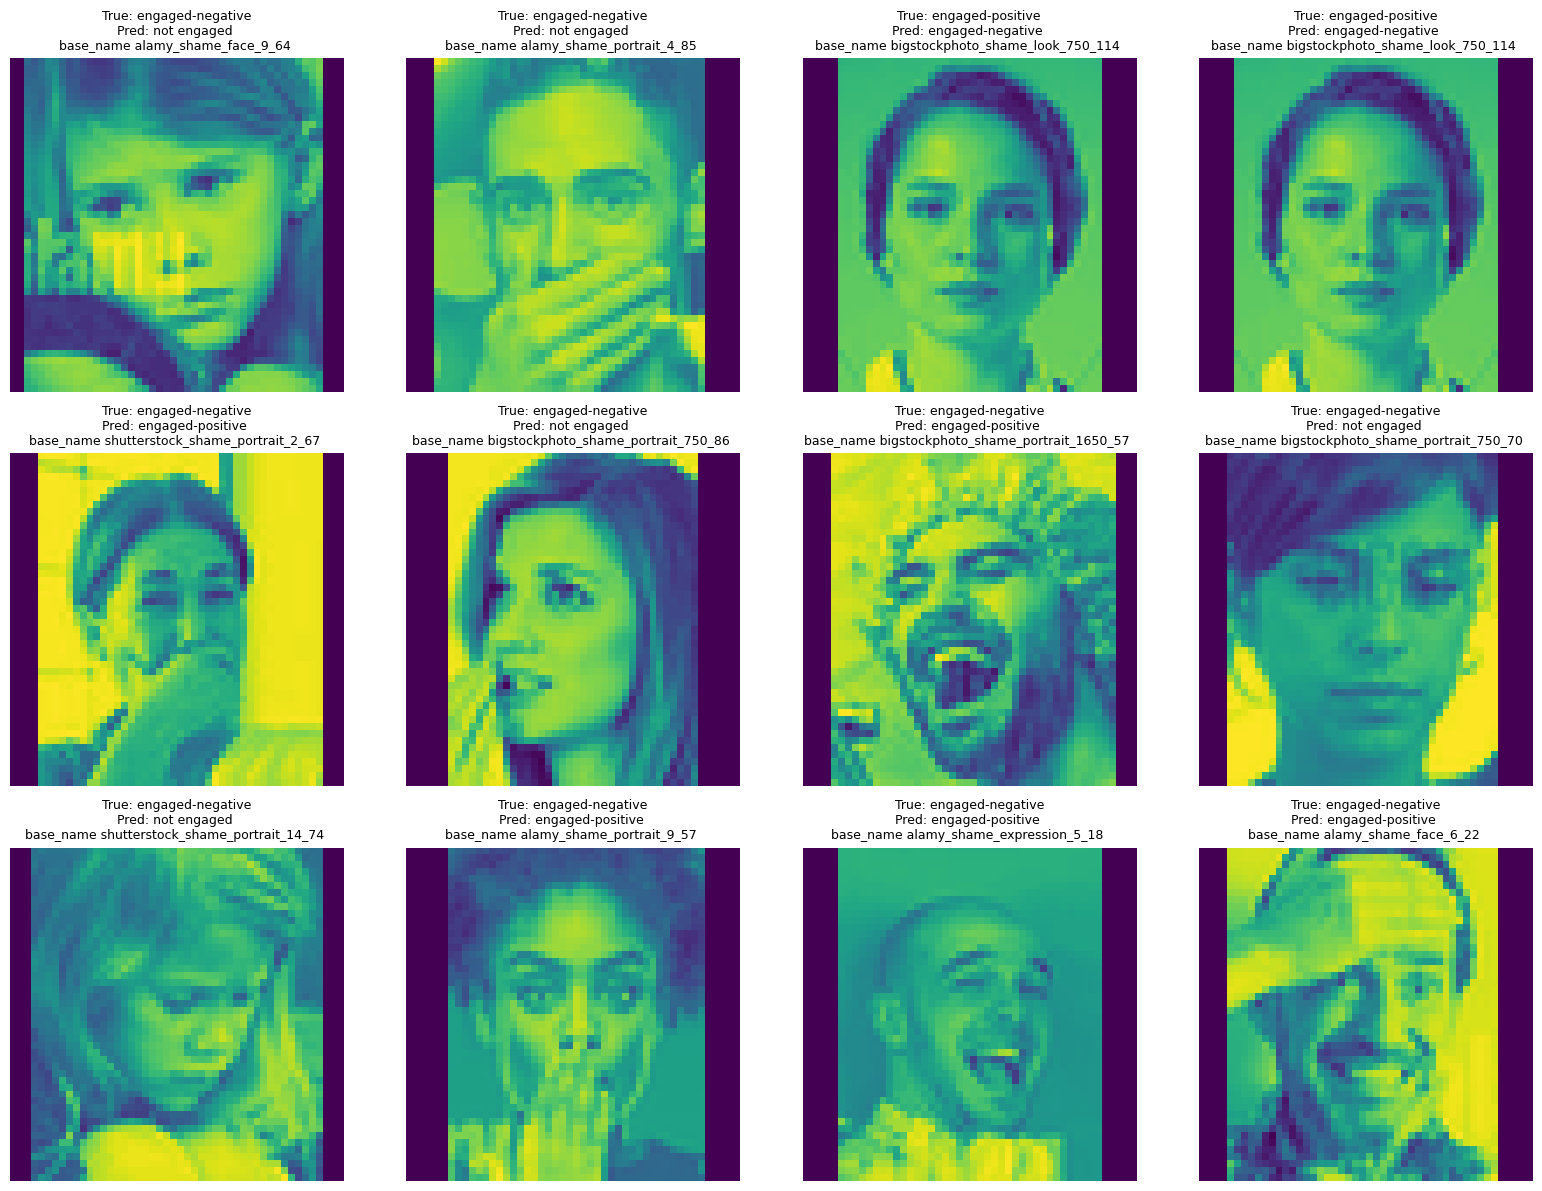

In [31]:
import matplotlib.pyplot as plt

# Filter for the specific case
filtered_df = colored_df[(colored_df['label'] == 'shame') & (colored_df['result'] == 'wrong')].head(48)

# Set up the plot grid
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))
axes = axes.flatten()

for i, (idx, row) in enumerate(filtered_df.iterrows()):
    img = row['image']  # PIL Image
    ax = axes[i]
    ax.imshow(img)
    ax.set_title(f"True: {row['engagement_type']}\nPred: {row['predicted engagement type']} \nbase_name {row['base_name']} ", fontsize=9)
    ax.axis('off')

# Hide any unused subplots (if less than 48 images)
for j in range(len(filtered_df), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


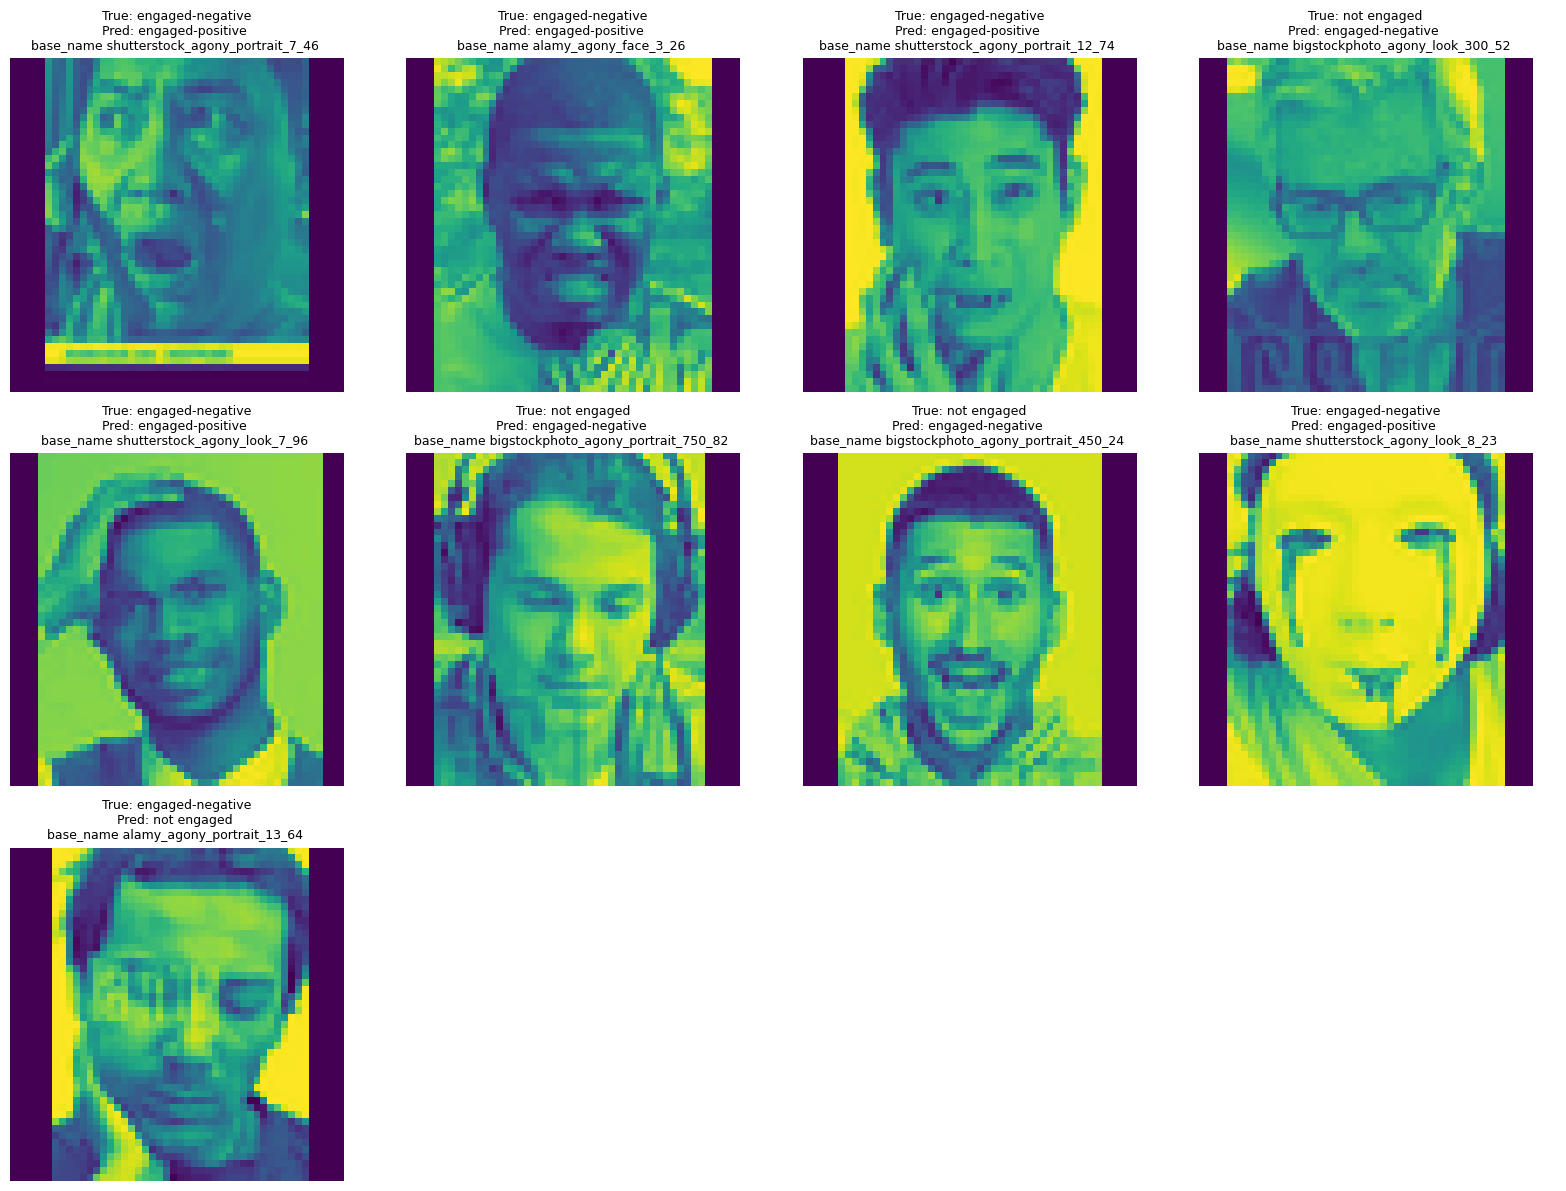

In [32]:
import matplotlib.pyplot as plt

# Filter for the specific case
filtered_df = colored_df[(colored_df['label'] == 'agony') & (colored_df['result'] == 'wrong')].head(48)

# Set up the plot grid
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))
axes = axes.flatten()

for i, (idx, row) in enumerate(filtered_df.iterrows()):
    img = row['image']  # PIL Image
    ax = axes[i]
    ax.imshow(img)
    ax.set_title(f"True: {row['engagement_type']}\nPred: {row['predicted engagement type']} \nbase_name {row['base_name']} ", fontsize=9)
    ax.axis('off')

# Hide any unused subplots (if less than 48 images)
for j in range(len(filtered_df), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


Comment: 

On these two examplese we can see that there are semantical issues, some pictures couldn't be properly classifies even by humans, however we see that for example by 'agony' there is still a space to train the model since the pictures are very clear. 

In [45]:
import cv2
import time
import torch
import numpy as np
from torchvision import transforms, models
from sklearn.preprocessing import LabelEncoder
import joblib  # If you saved your label encoder

# ========== DEVICE SETUP ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========== LOAD MODEL ==========
model = models.alexnet(pretrained=False)
model.classifier[6] = torch.nn.Linear(4096, 3)  # Adjust output to match your case
model.load_state_dict(torch.load("alexnet_best_finetuned.pth", map_location=device))
model.to(device)
model.eval()

# ========== LOAD LABEL ENCODER ==========
# If saved with joblib
# label_encoder = joblib.load("label_encoder.joblib")

# Otherwise, define manually
label_encoder_classes = ['bored', 'confused', 'focused']  # Adjust to your order
# If unsure, use: label_encoder.classes_.tolist()
def decode_label(index):
    return label_encoder_classes[index]

# ========== IMAGE TRANSFORM ==========
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ========== CAMERA LOOP ==========
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("❌ Could not open webcam.")
    exit()

print("📷 Webcam activated. Press Ctrl+C to stop.")

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("❌ Failed to capture frame.")
            break

        # Convert BGR (OpenCV) to RGB (PyTorch)
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Transform image
        input_tensor = transform(rgb).unsqueeze(0).to(device)

        # Predict
        with torch.no_grad():
            output = model(input_tensor)
            pred = torch.argmax(output, dim=1).item()
            label = decode_label(pred)

        print(f"🧠 Prediction: {label}")
        time.sleep(2)

except KeyboardInterrupt:
    print("\n🛑 Stopped by user.")

finally:
    cap.release()
    cv2.destroyAllWindows()


C:\Users\alina\AppData\Local\Temp\ipykernel_21764\3114076386.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("alexnet_best_finetuned.pt

📷 Webcam activated. Press Ctrl+C to stop.
🧠 Prediction: focused
🧠 Prediction: focused
🧠 Prediction: focused
🧠 Prediction: focused
🧠 Prediction: focused
🧠 Prediction: focused
🧠 Prediction: focused
🧠 Prediction: focused
🧠 Prediction: focused
🧠 Prediction: focused
🧠 Prediction: focused

🛑 Stopped by user.
